<div style="font-size:37px; font-weight:bold; line-height:1.1">
    DInSAR simulator: Illapel earthquake
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
This work has been created in projects supported by NASA and the US National Science Foundation (PI: Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook explores the simulation of synthetic interferogram. The simulation is done by mimicking the scene that leads to record an interferogram: a satellite passes over an area, sends a radar wave to the ground, and record the reflected signal. By doing so two times, or with another receiver away from the transmitter on the satellite, we get a difference in phase between the emitted and received signals due to a different look angle and a potential change in topography. This phase difference gives us the interferogram.

<img src="http://www.ga.gov.au/__data/assets/image/0008/22859/13-7402-1-sml1.jpg" width="800" align="left"/>
<div style="clear: left">
   Image source: [Commonwealth of Australia (Geoscience Australia)](http://www.ga.gov.au/scientific-topics/positioning-navigation/geodesy/geodetic-techniques/interferometric-synthetic-aperture-radar); image license: Creative Commons, [http://www.ga.gov.au/copyright](http://www.ga.gov.au/copyright)
</div>

Interferograms are used to obtain height values over a given area and compute digital elevation models, or to obtain the surface deformation over a given area. However, they record other signals, due to an imperfect satellite orbit or atmospheric perturbations. Being able to simulate synthetic interferograms can help to improve the algorithms extracting the height or the surface deformation.

# Package imports

If you rely on Openblas to solve linear systems with NumPy, you should consider using the following set_env. Openblas has multithreading capabilities that dramaticaly slow down the SGS when the neighborhood (so the system to solve) is small

In [ ]:
%set_env OPENBLAS_NUM_THREADS = 1

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy.ndimage.interpolation import rotate
from scipy import stats

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from skdaccess.utilities.srtm_util import merge_srtm_tiles
from getpass import getpass

from pyinsar.data_import.import_georaster import *
from pyinsar.output.export_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.processing.geography.geomorphometry import *
from pyinsar.processing.deformation.elastic_halfspace.okada import *
from pyinsar.processing.machine_learning.geostatistics.sequential_gaussian_simulation import *
from pyinsar.processing.utilities.insar_simulator_utils import *

# Goal

To illustrate the steps of computing a synthetic interferogram, we rely on a real interferogram computed following the 2015 Illapel earthquake, in Chile. This interferogram comes from data of the ALOS-2 satellite. The interferogram and more information about its computation can be found on Geospatial Information Authority of Japan's [website](http://www.gsi.go.jp/cais/topic151006-index-e.html).

Our goal is to produce a similar but synthetic interferogram.

# Scene definition

Let's first get some topography from the Shuttle Radar Topography Mission (SRTM). You need an [Earthdata](https://earthdata.nasa.gov/) account to recover the data from NASA repositories. Then, you can enter you login and password there:

In [2]:
username = ''
password = getpass()

········


Then, we get the tiles corresponding to the area covered by the real interferogram.

In [3]:
lon_min = -73
lon_max = -69
lat_min = -33
lat_max = -30

In [4]:
srtm_df = SRTM_DF(lat_tile_start = lat_min, lat_tile_end = lat_max - 1,
                  lon_tile_start = lon_min, lon_tile_end = lon_max - 1,
                  username = username, password = password)
srtm_tiles = srtm_df.output()

In [5]:
srtm_tiles.data.keys()

odict_keys(['S33W073', 'S32W073', 'S31W073', 'S33W072', 'S32W072', 'S31W072', 'S33W071', 'S32W071', 'S31W071', 'S33W070', 'S32W070', 'S31W070'])

We combine all the tiles into a single topography array, and create a GDAL raster.

In [6]:
topography, topography_extent = merge_srtm_tiles(srtm_tiles,
                                                 lon_min, lon_max,
                                                 lat_min, lat_max)

In [7]:
geotransform = (topography_extent[0], (topography_extent[1] - topography_extent[0])/topography.shape[1], 0.,
                topography_extent[3], 0., (topography_extent[2] - topography_extent[3])/topography.shape[0])
projection = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'
topography_raster = create_georaster_from_array(topography,           
                                                geotransform, 
                                                projection)

We project the topography into a Lambert Azimuthal Equal Area reference frame. All the following operations will be done using this projected frame.

In [8]:
projection_wkt = 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",-30],PARAMETER["longitude_of_center",-70.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
grid_yx_spacing = (60., 60.) # meter

projected_topography_raster = reproject_georaster(topography_raster, grid_yx_spacing, new_projection_wkt = projection_wkt)
print_georaster_info(projected_topography_raster)
projected_topography = get_georaster_array(projected_topography_raster)

projected_extent_meter = get_georaster_extent(projected_topography_raster)
projected_width = projected_topography.shape[1]
projected_height = projected_topography.shape[0]

xx, yy = compute_x_and_y_coordinates_maps(projected_extent_meter[0], projected_extent_meter[1], 
                                          projected_extent_meter[2], projected_extent_meter[3], 
                                          projected_width, projected_height)

projected_extent = []
for coordinate in projected_extent_meter:
    projected_extent.append(coordinate/1000.)

Driver:  MEM / In Memory Raster
Size of the cube is  6357 x 5515 x 1
Projection is  PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",-30],PARAMETER["longitude_of_center",-70.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]
Origin = ( -241196.0395283354 , -2602.9676445105156 )
Pixel Size = ( 60.0 , -60.0 )


<IPython.core.display.Javascript object>


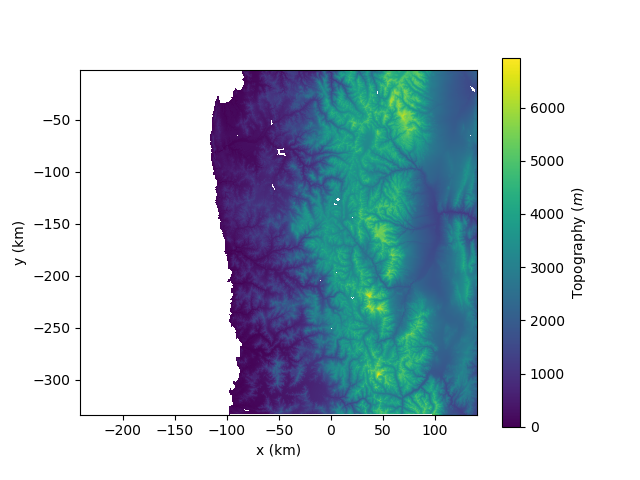

In [9]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(projected_topography), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Topography ($m$)')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

Now that we have the topography, we define the satellite location relative to the image and the satellite's characteristics. Here we use values close to those of the ALOS-2 mission. The location of the second receiver is defined in relation to the first one through the baseline and alpha:

<img src="InSAR_Principle.png" width="600" align="left"/>
<div style="clear: left">
</div>

Here, we consider that the position of the satellite at each pass is not precisely controlled. Most of the parameters vary randomly along the mean track direction.

In [10]:
is_right_looking = True

k = 2

wavelength = 0.2360 # m (L-band)

To compute the varying parameters, we first simulate their variation along the track direction (i.e., a 1D signal) using a [Sequential Gaussian Simulation](http://petrowiki.org/Geostatistical_conditional_simulation).

In [11]:
%%time

track_angle_mean = 190. # degree
track_angle_std = 0.25 # degree

track_angle_vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
track_angle_vario_sills = (0.00000001, 1.,)
track_angle_vario_azimuth = 0.
track_angle_vario_ranges = ((0., 0.), (100000., 100000.),) # m.

seed = 10

track_angle_length = projected_width + projected_width//4

data_array = np.full((track_angle_length, 1), -99999.)
track_angle = run_sgs(data_array,
                      grid_yx_spacing,
                      track_angle_vario_models,
                      track_angle_vario_sills,
                      track_angle_vario_azimuth,
                      track_angle_vario_ranges,
                      seed = seed)

track_angle_param = (track_angle_mean, track_angle_std)
track_angle = track_angle_param[1]*track_angle[0] + track_angle_param[0]

CPU times: user 13.7 s, sys: 744 ms, total: 14.4 s
Wall time: 14.9 s


Then, we extent the signal perpendicularly to the track direction, to obtain a value for each cell of the domain.

In [12]:
track_angle = np.tile(track_angle, (1, track_angle_length))
track_angle = rotate(track_angle, -track_angle_mean, reshape = False, cval = np.nan)
track_angle = crop_array_from_center(track_angle, projected_topography.shape)
rad_track_angle = track_angle*np.pi/180.

And we repeat for each parameter.

In [13]:
%%time

min_ground_range_mean = 290000. # m
min_ground_range_std = 0.25 # m

min_ground_range_vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
min_ground_range_vario_sills = (0.00000001, 1.,)
min_ground_range_vario_azimuth = 0.
min_ground_range_vario_ranges = ((0., 0.), (100000., 100000.),) # m.

seed += 1

min_ground_range_length = projected_width + projected_width//4

data_array = np.full((min_ground_range_length, 1), -99999.)
min_ground_range = run_sgs(data_array,
                   grid_yx_spacing,
                   min_ground_range_vario_models,
                   min_ground_range_vario_sills,
                   min_ground_range_vario_azimuth,
                   min_ground_range_vario_ranges,
                   seed = seed)

min_ground_range_param = (min_ground_range_mean, min_ground_range_std)
min_ground_range = min_ground_range_param[1]*min_ground_range[0] + min_ground_range_param[0]

CPU times: user 6.77 s, sys: 624 ms, total: 7.4 s
Wall time: 7.92 s


In [14]:
min_ground_range = np.tile(min_ground_range, (1, min_ground_range_length))
min_ground_range = rotate(min_ground_range, -track_angle_mean, reshape = False, cval = np.nan)
min_ground_range = crop_array_from_center(min_ground_range, projected_topography.shape)

In [15]:
%%time

satellite_height_mean = 630000. # m
satellite_height_std = 0.25 # m

satellite_height_vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
satellite_height_vario_sills = (0.00000001, 1.,)
satellite_height_vario_azimuth = 0.
satellite_height_vario_ranges = ((0., 0.), (100000., 100000.),) # m.

seed += 1

satellite_height_length = projected_width + projected_width//4

data_array = np.full((satellite_height_length, 1), -99999.)
satellite_height = run_sgs(data_array,
                   grid_yx_spacing,
                   satellite_height_vario_models,
                   satellite_height_vario_sills,
                   satellite_height_vario_azimuth,
                   satellite_height_vario_ranges,
                   seed = seed)

satellite_height_param = (satellite_height_mean, satellite_height_std)
satellite_height = satellite_height_param[1]*satellite_height[0] + satellite_height_param[0]

CPU times: user 6.16 s, sys: 586 ms, total: 6.74 s
Wall time: 6.9 s


In [16]:
satellite_height = np.tile(satellite_height, (1, satellite_height_length))
satellite_height = rotate(satellite_height, -track_angle_mean, reshape = False, cval = np.nan)
satellite_height = crop_array_from_center(satellite_height, projected_topography.shape)

In [17]:
%%time

baseline_mean = 214. # m
baseline_std = 0.25 # m

baseline_vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
baseline_vario_sills = (0.00000001, 1.,)
baseline_vario_azimuth = 0.
baseline_vario_ranges = ((0., 0.), (100000., 100000.),) # m.

seed += 1

baseline_length = projected_width + projected_width//4

data_array = np.full((baseline_length, 1), -99999.)
baseline = run_sgs(data_array,
                   grid_yx_spacing,
                   baseline_vario_models,
                   baseline_vario_sills,
                   baseline_vario_azimuth,
                   baseline_vario_ranges,
                   seed = seed)

baseline_param = (baseline_mean, baseline_std)
baseline = baseline_param[1]*baseline[0] + baseline_param[0]

CPU times: user 6.1 s, sys: 559 ms, total: 6.66 s
Wall time: 6.82 s


In [18]:
baseline = np.tile(baseline, (1, baseline_length))
baseline = rotate(baseline, -track_angle_mean, reshape = False, cval = np.nan)
baseline = crop_array_from_center(baseline, projected_topography.shape)

In [19]:
%%time

alpha_mean = 214. # m
alpha_std = 0.25 # m

alpha_vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
alpha_vario_sills = (0.00000001, 1.,)
alpha_vario_azimuth = 0.
alpha_vario_ranges = ((0., 0.), (100000., 100000.),) # m.

seed += 1

alpha_length = projected_width + projected_width//4

data_array = np.full((alpha_length, 1), -99999.)
alpha = run_sgs(data_array,
                   grid_yx_spacing,
                   alpha_vario_models,
                   alpha_vario_sills,
                   alpha_vario_azimuth,
                   alpha_vario_ranges,
                   seed = seed)

alpha_param = (alpha_mean, alpha_std)
alpha = alpha_param[1]*alpha[0] + alpha_param[0]

CPU times: user 7.68 s, sys: 747 ms, total: 8.43 s
Wall time: 10.7 s


In [20]:
alpha = np.tile(alpha, (1, alpha_length))
alpha = rotate(alpha, -track_angle_mean, reshape = False, cval = np.nan)
alpha = crop_array_from_center(alpha, projected_topography.shape)
rad_alpha = alpha*np.pi/180.

Let's define some vectors to visualize the satellite path and look direction on the maps.

In [21]:
track_ALD_coordinates = (projected_extent[1] - (projected_extent[1] - projected_extent[0])/9.,
                         projected_extent[2] + (projected_extent[3] - projected_extent[2])/9.)
track_vector = np.array([math.sin(track_angle_mean*np.pi/180.),
                         math.cos(track_angle_mean*np.pi/180.)])
track_vector /= np.sqrt(np.sum(track_vector**2))
track_vector *= (projected_extent[1] - projected_extent[0])/9.
ALD_vector = np.array([math.cos(track_angle_mean*np.pi/180.),
                       -math.sin(track_angle_mean*np.pi/180.)])
ALD_vector /= np.sqrt(np.sum(ALD_vector**2))
ALD_vector *= (projected_extent[1] - projected_extent[0])/20.

<IPython.core.display.Javascript object>


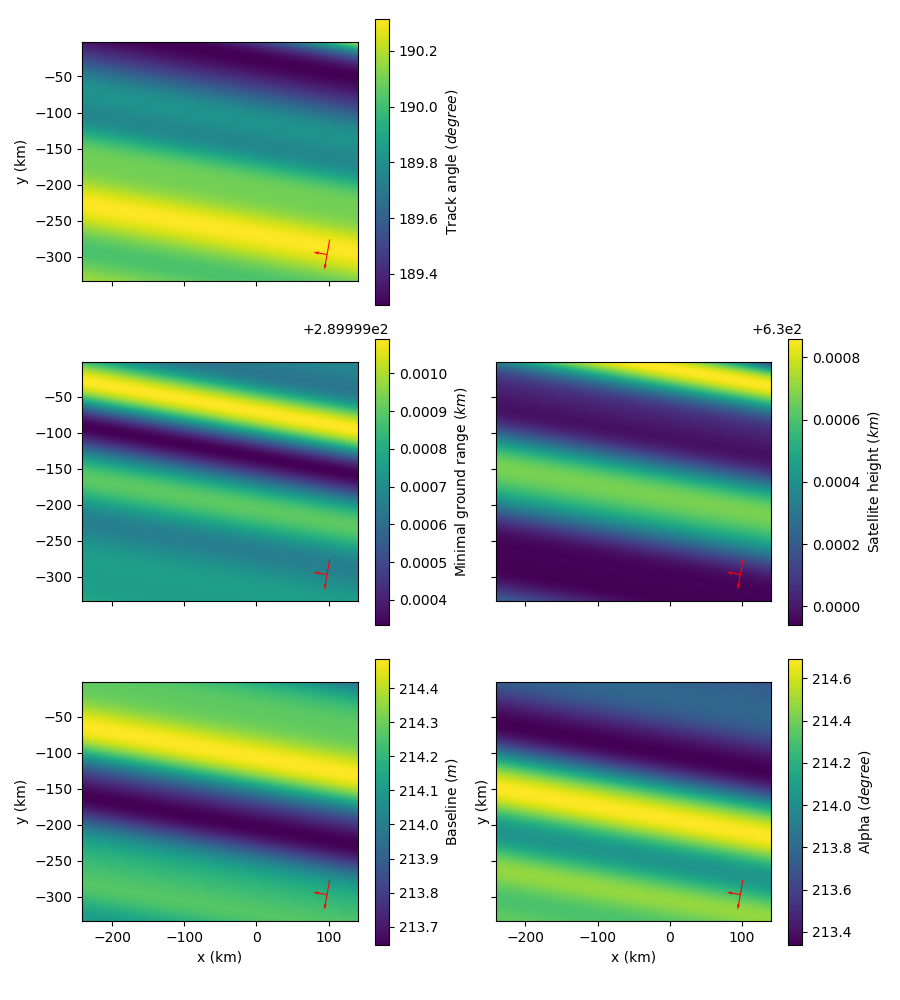

In [22]:
figure, subplots = plt.subplots(3, 2, sharex = True, sharey = True, figsize = (9, 10))

map_1 = subplots[0, 0].imshow(np.ma.masked_invalid(track_angle), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_1_colorbar = plt.colorbar(map_1, ax = subplots[0, 0])
map_1_colorbar.set_label('Track angle ($degree$)')
subplots[0, 0].set_ylabel('y (km)')

track_quiver = subplots[0, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                     track_vector[0], track_vector[1],
                                     scale = 1, pivot = 'mid', units = 'xy',
                                     width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplots[0, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                   ALD_vector[0], ALD_vector[1],
                                   scale = 1, units = 'xy',
                                   width = 1.5, color = 'red', zorder = 1)

subplots[0, 1].axis('off')

map_3 = subplots[1, 0].imshow(np.ma.masked_invalid(min_ground_range/1000.), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_3_colorbar = plt.colorbar(map_3, ax = subplots[1, 0])
map_3_colorbar.set_label('Minimal ground range ($km$)')

track_quiver = subplots[1, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                     track_vector[0], track_vector[1],
                                     scale = 1, pivot = 'mid', units = 'xy',
                                     width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplots[1, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                   ALD_vector[0], ALD_vector[1],
                                   scale = 1, units = 'xy',
                                   width = 1.5, color = 'red', zorder = 1)

map_4 = subplots[1, 1].imshow(np.ma.masked_invalid(satellite_height/1000.), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_4_colorbar = plt.colorbar(map_4, ax = subplots[1, 1])
map_4_colorbar.set_label('Satellite height ($km$)')

track_quiver = subplots[1, 1].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                     track_vector[0], track_vector[1],
                                     scale = 1, pivot = 'mid', units = 'xy',
                                     width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplots[1, 1].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                   ALD_vector[0], ALD_vector[1],
                                   scale = 1, units = 'xy',
                                   width = 1.5, color = 'red', zorder = 1)

map_5 = subplots[2, 0].imshow(np.ma.masked_invalid(baseline), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_5_colorbar = plt.colorbar(map_5, ax = subplots[2, 0])
map_5_colorbar.set_label('Baseline ($m$)')
subplots[2, 0].set_xlabel('x (km)')
subplots[2, 0].set_ylabel('y (km)')

track_quiver = subplots[2, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                     track_vector[0], track_vector[1],
                                     scale = 1, pivot = 'mid', units = 'xy',
                                     width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplots[2, 0].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                   ALD_vector[0], ALD_vector[1],
                                   scale = 1, units = 'xy',
                                   width = 1.5, color = 'red', zorder = 1)

map_6 = subplots[2, 1].imshow(np.ma.masked_invalid(alpha), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
map_6_colorbar = plt.colorbar(map_6, ax = subplots[2, 1])
map_6_colorbar.set_label('Alpha ($degree$)')
subplots[2, 1].set_xlabel('x (km)')
subplots[2, 1].set_ylabel('y (km)')

track_quiver = subplots[2, 1].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                     track_vector[0], track_vector[1],
                                     scale = 1, pivot = 'mid', units = 'xy',
                                     width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplots[2, 1].quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                   ALD_vector[0], ALD_vector[1],
                                   scale = 1, units = 'xy',
                                   width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

# Receivers' geographic coordinates

We determine the coordinates of the receiver during the two passes in the projected reference frame. By knowing the target's coordinates (i.e., the topography) and the satellite's coordinates, we will be able to compute an interferogram.

In [23]:
baseline_horizontal = baseline*np.cos(rad_alpha)
baseline_vertical = baseline*np.sin(rad_alpha)

horizontal_incidence_vector = np.array([-np.cos(rad_track_angle),
                                        np.sin(rad_track_angle)])
if is_right_looking == False:
    horizontal_incidence_vector *= -1.

In [24]:
cross_track_distance = xx*np.cos(rad_track_angle) - yy*np.sin(rad_track_angle)
if is_right_looking == False:
    cross_track_distance *= -1.
cross_track_distance -= cross_track_distance.min()

ground_range = cross_track_distance + min_ground_range
ground_range[np.isnan(projected_topography)] = np.nan

In [25]:
satellite_xx_1 = xx + ground_range*horizontal_incidence_vector[0]
satellite_yy_1 = yy + ground_range*horizontal_incidence_vector[1]

In [26]:
satellite_xx_2 = satellite_xx_1 - baseline_horizontal*horizontal_incidence_vector[0]
satellite_yy_2 = satellite_yy_1 - baseline_horizontal*horizontal_incidence_vector[1]
satellite_height_2 = satellite_height + baseline_vertical

# Interferogram from the scene

Computing an interferogram from the coordinates of the domain and satellite is done in three steps:
* For each pass, computing the distance between the satellite and each cell of the domain, called slant range.
* For each pass, computing the phase from the slant range.
* Computing the interferogram from the difference of the phases.

We start by computing an interferogram for a scene without any perturbation. The interferogram's components are just the viewing angle and the topography (there is no component due to the ellipsoidicity of the Earth, because we are in a projected reference frame).

In [27]:
slant_range_1_scene = np.sqrt((xx - satellite_xx_1)**2
                              + (yy - satellite_yy_1)**2
                              + (projected_topography - satellite_height)**2)
slant_range_2_scene = np.sqrt((xx - satellite_xx_2)**2
                              + (yy - satellite_yy_2)**2
                              + (projected_topography - satellite_height_2)**2)

<IPython.core.display.Javascript object>


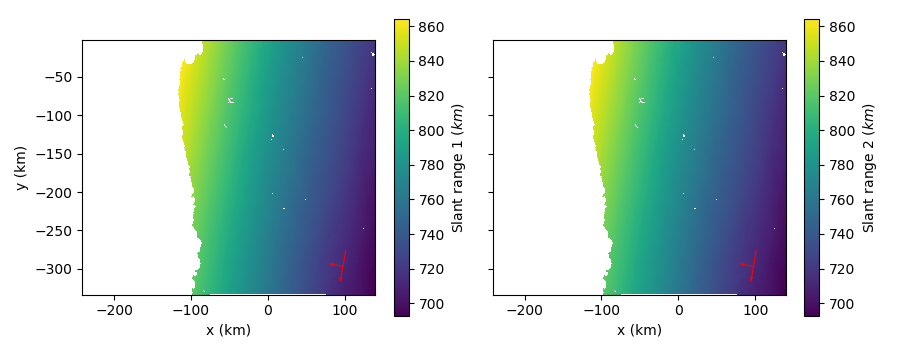

In [28]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

raster_1_map = subplot1.imshow(np.ma.masked_invalid(slant_range_1_scene/1000.),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_1_colorbar = plt.colorbar(raster_1_map, ax = subplot1)
raster_1_colorbar.set_label('Slant range 1 ($km$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

track_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

raster_2_map = subplot2.imshow(np.ma.masked_invalid(slant_range_2_scene/1000.),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_2_colorbar = plt.colorbar(raster_2_map, ax = subplot2)
raster_2_colorbar.set_label('Slant range 2 ($km$)')
subplot2.set_xlabel('x (km)')

track_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

In [29]:
phase_1_scene = wrap(-2.*np.pi*k*slant_range_1_scene/wavelength, to_2pi = True)
phase_2_scene = wrap(-2.*np.pi*k*slant_range_2_scene/wavelength, to_2pi = True)

<IPython.core.display.Javascript object>


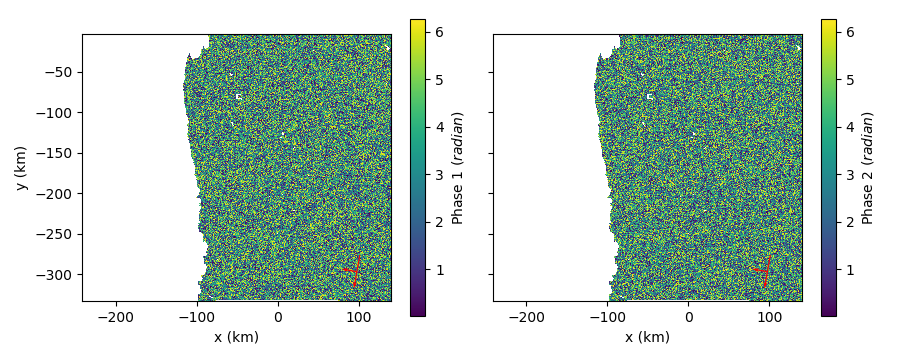

In [30]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

phase_1_map = subplot1.imshow(np.ma.masked_invalid(phase_1_scene),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
phase_1_colorbar = plt.colorbar(phase_1_map, ax = subplot1)
phase_1_colorbar.set_label('Phase 1 ($radian$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

track_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

phase_2_map = subplot2.imshow(np.ma.masked_invalid(phase_2_scene),
                                        extent = projected_extent,
                                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                                        zorder = 0)
phase_2_colorbar = plt.colorbar(phase_2_map, ax = subplot2)
phase_2_colorbar.set_label('Phase 2 ($radian$)')
subplot2.set_xlabel('x (km)')

track_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

In [31]:
wrapped_interferogram_scene = wrap(phase_1_scene - phase_2_scene)

<IPython.core.display.Javascript object>


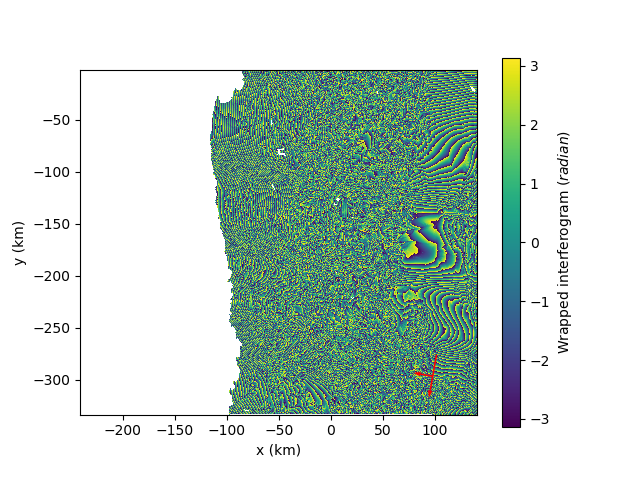

In [32]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(wrapped_interferogram_scene), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Wrapped interferogram ($radian$)')

track_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                track_vector[0], track_vector[1],
                                scale = 1, pivot = 'mid', units = 'xy',
                                width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                              ALD_vector[0], ALD_vector[1],
                              scale = 1, units = 'xy',
                              width = 1.5, color = 'red', zorder = 1)

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

# Simulating scene perturbations

Now we want to simulate different types of perturbations that introduce new components into the interferogram.

## Surface deformation

The surface deformation corresponds to a change in topography due to earthquakes, volcanic activity, aquifer variations, etc. They induce a change in the slant range between the two passes, thus are recorded by the interferogram.

The Illapel earthquake is linked to a subduction zone, where the oceanic Nazca plate dives under the continental South American plate.

<img src="https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/subzon.gif?itok=GopmpfUp" width="500" align="left"/>
<div style="clear: left">
   [Image source: U.S. Geological Survey](https://www.usgs.gov/media/images/subduction-fault-zone-diagram)
</div>

For simplicity, we model the rupture area as a single rectangular plane using [Okada's analytical solution](https://pubs.geoscienceworld.org/ssa/bssa/article/75/4/1135/118782/surface-deformation-due-to-shear-and-tensile). It returns us a 3D displacement field corresponding to the surface deformation. This solution has several flaws if the goal is to accurately model the deformation, but it is good enough for our goal.

In [33]:
fault_centroid_lon = -72.22 # degree
fault_centroid_lat = -31.1 # degree
fault_top_depth = 100. # meter
fault_strike = 9. # degree
fault_dip = 22. # degree
fault_length = 140000. # meter
fault_width = 85000. # meter
fault_rake = 92 # degree
fault_slip = 4. # meter
fault_open = 0. # meter
poisson_ratio = 0.25

In [34]:
%%time

fault_centroid_xyz = reproject_point(fault_centroid_lon,
                                     fault_centroid_lat,
                                     old_projection_wkt = projection,
                                     new_projection_wkt = projection_wkt)

fault_centroid_depth = fault_top_depth + math.sin(fault_dip)*fault_width/2.

displacement = compute_okada_displacement(fault_centroid_xyz[0],
                                          fault_centroid_xyz[1],
                                          fault_centroid_depth,
                                          fault_strike*np.pi/180.,
                                          fault_dip*np.pi/180.,
                                          fault_length,
                                          fault_width,
                                          fault_rake*np.pi/180.,
                                          fault_slip,
                                          fault_open,
                                          poisson_ratio,
                                          xx,
                                          yy)
displacement[:, np.isnan(projected_topography)] = np.nan

CPU times: user 2min 36s, sys: 2min 10s, total: 4min 46s
Wall time: 5min 19s


<IPython.core.display.Javascript object>


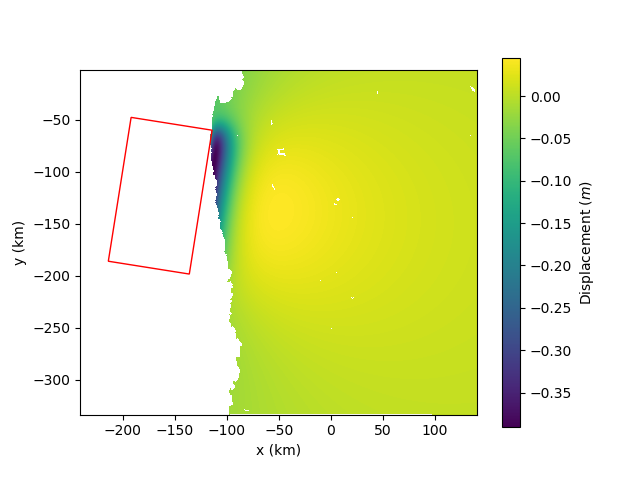

In [35]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(displacement[2,:,:]), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

okada_x_1 = (fault_length)/2.
okada_x_2 = (fault_length)/2.
okada_x_3 = -(fault_length)/2.
okada_x_4 = -(fault_length)/2.
okada_y_1 = math.cos(fault_dip*np.pi/180.)*(fault_width)/2.
okada_y_2 = -math.cos(fault_dip*np.pi/180.)*(fault_width)/2.
okada_y_3 = -math.cos(fault_dip*np.pi/180.)*(fault_width)/2.
okada_y_4 = math.cos(fault_dip*np.pi/180.)*(fault_width)/2.
fault_x_1 = fault_centroid_xyz[0] + math.sin(fault_strike*np.pi/180.)*okada_x_1 - math.cos(fault_strike*np.pi/180.)*okada_y_1
fault_x_2 = fault_centroid_xyz[0] + math.sin(fault_strike*np.pi/180.)*okada_x_2 - math.cos(fault_strike*np.pi/180.)*okada_y_2
fault_x_3 = fault_centroid_xyz[0] + math.sin(fault_strike*np.pi/180.)*okada_x_3 - math.cos(fault_strike*np.pi/180.)*okada_y_3
fault_x_4 = fault_centroid_xyz[0] + math.sin(fault_strike*np.pi/180.)*okada_x_4 - math.cos(fault_strike*np.pi/180.)*okada_y_4
fault_y_1 = fault_centroid_xyz[1] + math.cos(fault_strike*np.pi/180.)*okada_x_1 + math.sin(fault_strike*np.pi/180.)*okada_y_1
fault_y_2 = fault_centroid_xyz[1] + math.cos(fault_strike*np.pi/180.)*okada_x_2 + math.sin(fault_strike*np.pi/180.)*okada_y_2
fault_y_3 = fault_centroid_xyz[1] + math.cos(fault_strike*np.pi/180.)*okada_x_3 + math.sin(fault_strike*np.pi/180.)*okada_y_3
fault_y_4 = fault_centroid_xyz[1] + math.cos(fault_strike*np.pi/180.)*okada_x_4 + math.sin(fault_strike*np.pi/180.)*okada_y_4

fault = Polygon([(fault_x_1/1000., fault_y_1/1000.),
                 (fault_x_2/1000., fault_y_2/1000.),
                 (fault_x_3/1000., fault_y_3/1000.),
                 (fault_x_4/1000., fault_y_4/1000.)], fill = False, edgecolor = 'red')
subfigure.add_patch(fault)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Displacement ($m$)')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

## Atmospheric delays

When the radar pulse goes through the atmosphere, it is more or less delayed depending on the water content. We simulate such delay using a [Sequential Gaussian Simulation](http://petrowiki.org/Geostatistical_conditional_simulation) (SGS). It is a stochastic method to simulate spatial random field. The spatial structure of those fields is described by a [variogram](https://en.wikipedia.org/wiki/Variogram).

Several factors can influence the atmospheric delays, and we use some of them as secondary property, which influence the spatial structure of the random field. Here we retain two factors: the topography and the slant range. Usually the water content is higher in valleys, increasing the delay. A longer slant range means a longer travel time through the atmosphere, which also increases the delay. We combine those two properties into a single secondary property [(Babak and Deutsch, 2009)](https://doi.org/10.1016/j.petrol.2009.08.001) to facilitate the simulation in the next step.

In [36]:
secondary_data_topography = standardize(projected_topography)
secondary_data_slant_range_1 = standardize(slant_range_1_scene)

secondary_data_1 = np.array([secondary_data_topography, secondary_data_slant_range_1])

correlations_with_primary = np.ones((secondary_data_1.shape[0]))
correlations_with_primary[0] = -0.1
correlations_with_primary[1] = 0.1

correlations_between_secondary = np.ones((secondary_data_1.shape[0], secondary_data_1.shape[0]))
correlations_between_secondary[0, 1] = 0.
correlations_between_secondary[1, 0] = correlations_between_secondary[0, 1]

In [37]:
merged_secondary_data_1, merged_secondary_data_1_weight = merge_secondary_data(secondary_data_1,
                                                                               correlations_with_primary,
                                                                               correlations_between_secondary)

<IPython.core.display.Javascript object>


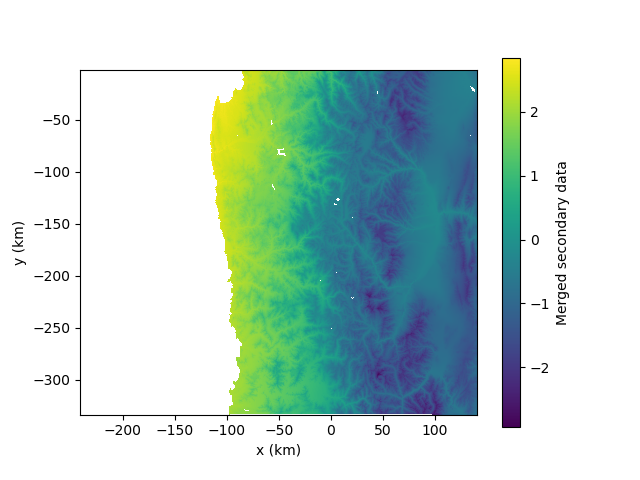

In [38]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(merged_secondary_data_1), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Merged secondary data')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

Now we simulate the atmospheric delay for each pass using the SGS. The idea is to loop through the grid in a random order, and to use an [intrinsic collocated cokriging](https://doi.org/10.1016/j.cageo.2008.02.025) system to reproduce the variogram into the random field.

In [39]:
%%time

data_array = np.full((projected_height, projected_width), -99999.)
data_array[np.isnan(projected_topography)] = math.nan

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
vario_sills = (0.0001, 1.,)
vario_azimuth = 0.
vario_ranges = ((0., 0.), (95000., 95000.),) # meter

max_number_data = 20

seed = 100

raw_atmospheric_delay_1 = run_sgs(data_array,
                                  grid_yx_spacing,
                                  vario_models,
                                  vario_sills,
                                  vario_azimuth,
                                  vario_ranges,
                                  max_number_data = max_number_data,
                                  secondary_data_weight = merged_secondary_data_1_weight,
                                  secondary_data_array = merged_secondary_data_1,
                                  seed = seed)

CPU times: user 12min 2s, sys: 8.46 s, total: 12min 10s
Wall time: 13min 23s


In [40]:
%%time

atmospheric_delay_mean = 0.02
atmospheric_delay_std = 0.01
atmospheric_delay_1 = atmospheric_delay_std*raw_atmospheric_delay_1[0] + atmospheric_delay_mean

CPU times: user 135 ms, sys: 114 ms, total: 249 ms
Wall time: 287 ms


In [41]:
%%time

vario_models = (VariogramModel.NUGGET, VariogramModel.GAUSSIAN,)
vario_sills = (0.0001, 1.,)
vario_azimuth = 0.
vario_ranges = ((0., 0.), (95000., 95000.),) # meter

seed += 1

raw_atmospheric_delay_2 = run_sgs(data_array,
                                  grid_yx_spacing,
                                  vario_models,
                                  vario_sills,
                                  vario_azimuth,
                                  vario_ranges,
                                  max_number_data = max_number_data,
                                  secondary_data_weight = merged_secondary_data_1_weight,
                                  secondary_data_array = merged_secondary_data_1,
                                  seed = seed)

CPU times: user 11min 42s, sys: 7.82 s, total: 11min 50s
Wall time: 12min 39s


In [42]:
%%time

atmospheric_delay_mean = 0.6
atmospheric_delay_std = 0.15
atmospheric_delay_2 = atmospheric_delay_std*raw_atmospheric_delay_2[0] + atmospheric_delay_mean

CPU times: user 133 ms, sys: 120 ms, total: 253 ms
Wall time: 256 ms


<IPython.core.display.Javascript object>


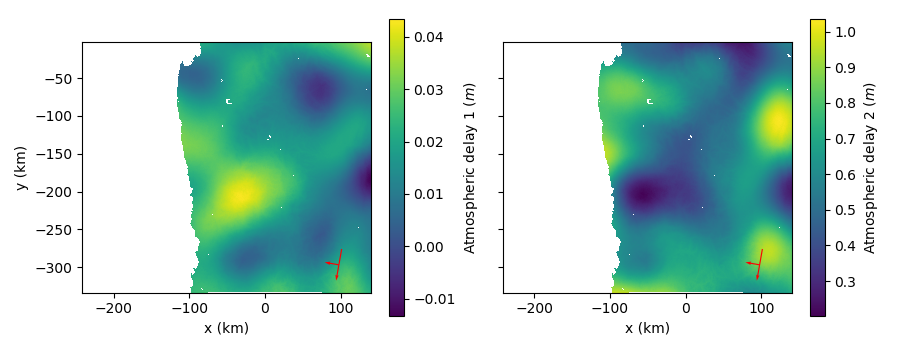

In [43]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

raster_1_map = subplot1.imshow(np.ma.masked_invalid(atmospheric_delay_1),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_1_colorbar = plt.colorbar(raster_1_map, ax = subplot1)
raster_1_colorbar.set_label('Atmospheric delay 1 ($m$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

track_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

raster_2_map = subplot2.imshow(np.ma.masked_invalid(atmospheric_delay_2),
                               extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_2_colorbar = plt.colorbar(raster_2_map, ax = subplot2)
raster_2_colorbar.set_label('Atmospheric delay 2 ($m$)')
subplot2.set_xlabel('x (km)')

track_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

## Temporal decorrelation

Another usual and significant component of interferograms is the temporal decorrelation. It comes from small-scale changes of the surface between two passes, which add noise to the interferogram, blurring or even masking the other components. Those changes can be due to crop growth, leaf growth or fall, rock fall, etc. Here, we use the SGS again to simulate small patches representing those variations.

In [44]:
%%time

data_array = np.full((projected_height, projected_width), -99999.)
data_array[np.isnan(projected_topography)] = math.nan

vario_models = (VariogramModel.SPHERICAL,)
vario_sills = (1.,)
vario_azimuth = 0.
vario_ranges = ((200., 200.),) # m

max_number_data = 20

seed += 1

raw_temporal_decorrelation = run_sgs(data_array,
                                     grid_yx_spacing,
                                     vario_models,
                                     vario_sills,
                                     vario_azimuth,
                                     vario_ranges,
                                     max_number_data = max_number_data,
                                     seed = seed)

CPU times: user 3min 8s, sys: 1.6 s, total: 3min 9s
Wall time: 3min 14s


Then, we classify the image into two areas depending on the slope:
* A first area corresponds to low slopes, delimitating the bottom of valleys or the coastal areas. In this area, we assign a high decorrelation to the Gaussian distribution of the random field previously simulated, due to galciers, rivers, and human activity.
* A second area corresponds to high slopes, mainly mountain sides. In this area, we convert the random field to an exponential distribution with a lower decorrelation. Overall, the decorrelation is more spatially limited than in the first area, corresponding to rock falls and changes in vegetation.

Note however that this classification is more an example of what can be achieved using SGS to model the temporal decorrelation than an actual model based on real constraints.

In [45]:
slope_limit = 5. # degree

slope = compute_horne_slope(projected_topography, 
                            grid_yx_spacing)
classified_areas = np.full(slope.shape, np.nan)
classified_areas[slope < slope_limit] = 1
classified_areas[slope >= slope_limit] = 2

/Users/grongier/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/grongier/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal


<IPython.core.display.Javascript object>


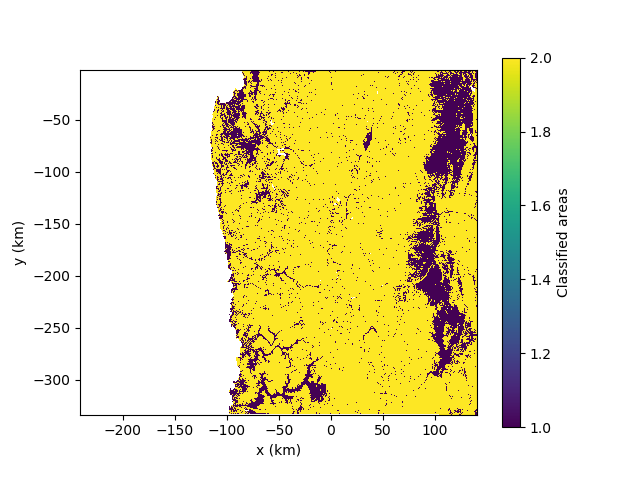

In [46]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(classified_areas), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Classified areas')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

In [47]:
temporal_decorrelation = np.full(slope.shape, np.nan)

temporal_decorrelation_mean = 0. # meter
temporal_decorrelation_std = 0.04 # meter
temporal_decorrelation[classified_areas == 1] = temporal_decorrelation_std*raw_temporal_decorrelation[0][classified_areas == 1] + temporal_decorrelation_mean

temporal_decorrelation_mean = 0. # meter
temporal_decorrelation_std = 0.015 # meter
cumulative_frequency = compute_averaged_cumulative_distribution_from_array(raw_temporal_decorrelation[0])
temporal_decorrelation[classified_areas == 2] = stats.expon.ppf(cumulative_frequency[classified_areas == 2],
                                                                loc = temporal_decorrelation_mean,
                                                                scale = temporal_decorrelation_std)

<IPython.core.display.Javascript object>


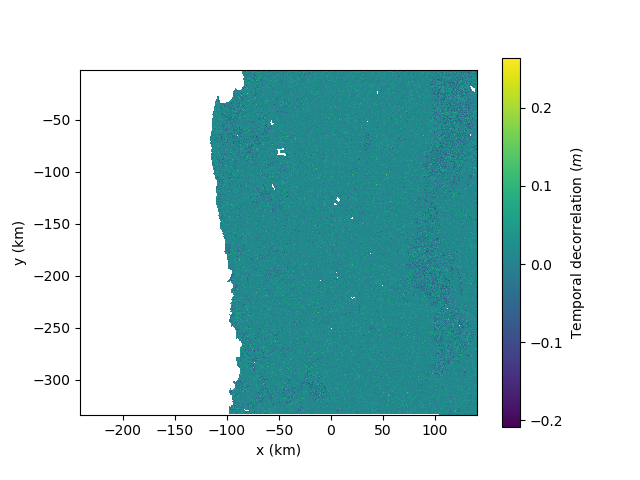

In [48]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(temporal_decorrelation), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Temporal decorrelation ($m$)')

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

# Interferogram with scene perturbations

We can now compute the final interferogram, which includes components from: the viewing angle, the topography, the surface deformation (i.e., the earthquake), the atmospheric delays, and the temporal decorrelation.

In [49]:
slant_range_1 = np.sqrt((xx - satellite_xx_1)**2
                        + (yy - satellite_yy_1)**2
                        + (projected_topography - satellite_height)**2) \
                + atmospheric_delay_1
slant_range_2 = np.sqrt((xx + displacement[0] - satellite_xx_2)**2
                        + (yy + displacement[1] - satellite_yy_2)**2
                        + (projected_topography + displacement[2] - satellite_height_2)**2) \
                + atmospheric_delay_2 \
                + temporal_decorrelation

<IPython.core.display.Javascript object>


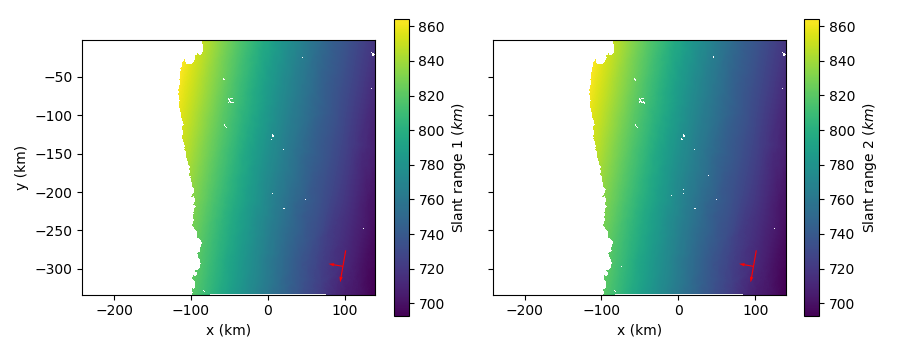

In [50]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

raster_1_map = subplot1.imshow(np.ma.masked_invalid(slant_range_1/1000.), extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_1_colorbar = plt.colorbar(raster_1_map, ax = subplot1)
raster_1_colorbar.set_label('Slant range 1 ($km$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

track_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

raster_2_map = subplot2.imshow(np.ma.masked_invalid(slant_range_2/1000.), extent = projected_extent,
                               cmap = 'viridis', interpolation = 'None', rasterized = True,
                               zorder = 0)
raster_2_colorbar = plt.colorbar(raster_2_map, ax = subplot2)
raster_2_colorbar.set_label('Slant range 2 ($km$)')
subplot2.set_xlabel('x (km)')

track_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

In [51]:
phase_1 = wrap(-2.*np.pi*k*slant_range_1/wavelength, to_2pi = True)
phase_2 = wrap(-2.*np.pi*k*slant_range_2/wavelength, to_2pi = True)

<IPython.core.display.Javascript object>


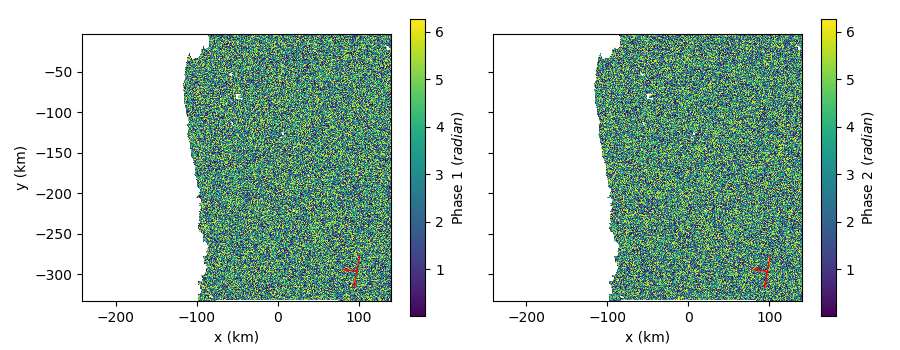

In [52]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (9, 3.5))

phase_1_map = subplot1.imshow(np.ma.masked_invalid(phase_1), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
phase_1_colorbar = plt.colorbar(phase_1_map, ax = subplot1)
phase_1_colorbar.set_label('Phase 1 ($radian$)')
subplot1.set_xlabel('x (km)')
subplot1.set_ylabel('y (km)')

track_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot1.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

phase_2_map = subplot2.imshow(np.ma.masked_invalid(phase_2), extent = projected_extent,
                              cmap = 'viridis', interpolation = 'None', rasterized = True,
                              zorder = 0)
phase_2_colorbar = plt.colorbar(phase_2_map, ax = subplot2)
phase_2_colorbar.set_label('Phase 2 ($radian$)')
subplot2.set_xlabel('x (km)')

track_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                               track_vector[0], track_vector[1],
                               scale = 1, pivot = 'mid', units = 'xy',
                               width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subplot2.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                             ALD_vector[0], ALD_vector[1],
                             scale = 1, units = 'xy',
                             width = 1.5, color = 'red', zorder = 1)

plt.tight_layout()

plt.show()

In [53]:
wrapped_interferogram = wrap(phase_1 - phase_2)

<IPython.core.display.Javascript object>


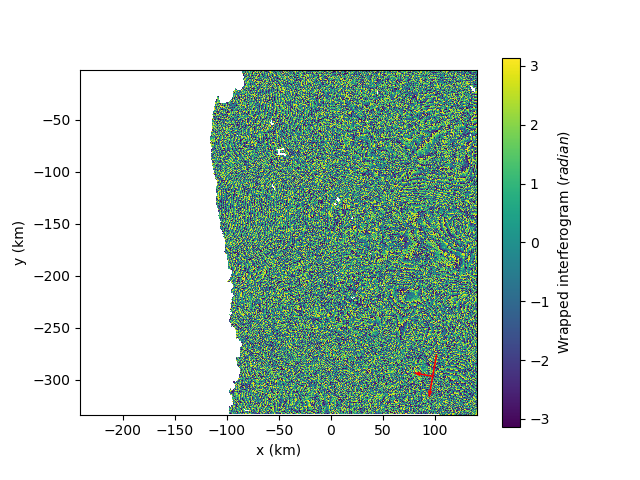

In [54]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(wrapped_interferogram), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Wrapped interferogram ($radian$)')

track_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                track_vector[0], track_vector[1],
                                scale = 1, pivot = 'mid', units = 'xy',
                                width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                              ALD_vector[0], ALD_vector[1],
                              scale = 1, units = 'xy',
                              width = 1.5, color = 'red', zorder = 1)

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()

Our previous interferogram doesn't look like the one captured by ALOS-2, because topographic effects were already removed from this real example. We do the same with our synthetic interferogram, by removing interferogram of the scene without perturbations computed previously from the final interferogram.

In [55]:
wrapped_interferogram_perturbations = wrap(wrapped_interferogram - wrapped_interferogram_scene)

<IPython.core.display.Javascript object>


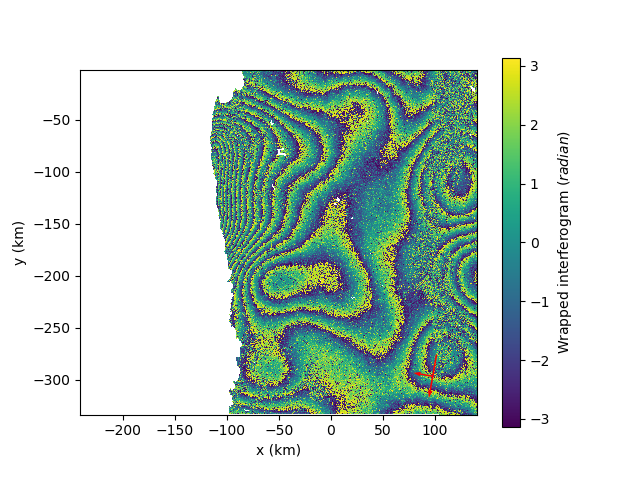

In [56]:
figure = plt.figure()
subfigure = figure.add_subplot(111)

raster_map = plt.imshow(np.ma.masked_invalid(wrapped_interferogram_perturbations), extent = projected_extent,
                        cmap = 'viridis', interpolation = 'None', rasterized = True,
                        zorder = 0)

raster_map_colorbar = plt.colorbar(raster_map)
raster_map_colorbar.set_label('Wrapped interferogram ($radian$)')

track_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                                track_vector[0], track_vector[1],
                                scale = 1, pivot = 'mid', units = 'xy',
                                width = 1.5, color = 'red', zorder = 1)
ALD_quiver = subfigure.quiver(track_ALD_coordinates[0], track_ALD_coordinates[1],
                              ALD_vector[0], ALD_vector[1],
                              scale = 1, units = 'xy',
                              width = 1.5, color = 'red', zorder = 1)

subfigure.set_xlabel('x (km)')
subfigure.set_ylabel('y (km)')
                
plt.show()